# Shoes Sandals Boots Image Classification using TensorFlow with CNN

## Install and Cofig Kaggle

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
upload = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


## Download File Dataset


In [5]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

 89% 42.0M/47.0M [00:00<00:00, 58.9MB/s]
100% 47.0M/47.0M [00:00<00:00, 55.1MB/s]


## Extract The Downloaded File and Create Directory for Train Set and Validation Set

In [6]:
import zipfile
import os

# Extract file zip
zip_dir = "/content/shoe-vs-sandal-vs-boot-dataset-15k-images.zip"
zip = zipfile.ZipFile(zip_dir, 'r')
zip.extractall('/content/')
zip.close()

os.rename("/content/Shoe vs Sandal vs Boot Dataset", "/content/ssb")

In [7]:
# Spliting train set and validation set
base_dir = '/content/ssb'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

## Spliting Images Dataset

In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define base directory and class labels
base_dir = "/content/ssb"
classes = ["Shoe", "Sandal", "Boot"]

# Create train and validation directories (handling existence)
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Function to split images for each class
def split_class_images(class_dir, test_size=0.2, random_state=42):
  images = os.listdir(class_dir)
  train_images, val_images = train_test_split(images, test_size=test_size, random_state=random_state)

  # Move images to train and validation directories
  for img in train_images:
    src = os.path.join(class_dir, img)
    dst = os.path.join(train_dir, class_name, img)  # Include class name in destination
    os.makedirs(os.path.dirname(dst), exist_ok=True)  # Create subdirectories if needed
    shutil.move(src, dst)  # Use move instead of copy for efficiency

  for img in val_images:
    src = os.path.join(class_dir, img)
    dst = os.path.join(val_dir, class_name, img)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.move(src, dst)

# Split images for each class
for class_name in classes:
  class_dir = os.path.join(base_dir, class_name)
  split_class_images(class_dir)

# Print confirmation message
print(f"Dataset Splitting Completed!\nTrain Folder: {os.listdir(train_dir)}\nValidation Folder: {os.listdir(val_dir)}")


Dataset Splitting Completed!
Train Folder: ['Shoe', 'Sandal', 'Boot']
Validation Folder: ['Shoe', 'Sandal', 'Boot']


## Create Image Classification Model using Tensorflow, Image Data Generator, CNN and Adam Optimizer

In [9]:
# Create Callback
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy')>0.92):
      print("Accuracy have been achieved!")
      self.model.stop_training = True
callbacks= Callback()

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = "/content/ssb"
classes = ["Boot", "Sandal", "Shoe"]

# Create train and validation directories (handling existence)
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Image dimensions (adjust based on your image size)
img_width, img_height = 50, 50

# Data augmentation parameters (optional, adjust as needed)
train_datagen = ImageDataGenerator(rescale=1./255,  # Rescale pixel values to [0, 1]
                                   shear_range=0.2,  # Randomly shear images
                                   zoom_range=0.2,  # Randomly zoom images
                                   horizontal_flip=True)  # Randomly flip images horizontally

val_datagen = ImageDataGenerator(rescale=1./255)  # Rescale only for validation

# Create training and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical')  # One-hot encoding for multiple classes

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')


# Use a function to define the image classification model for reusability
def create_image_classification_model(input_shape=(50, 50, 3), num_classes=3):
  model = tf.keras.Sequential([

      tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D((2,2), strides = (2, 2)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Conv2D(32, (3,3), padding = 'Same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
      tf.keras.layers.Dropout(0.5),

      tf.keras.layers.Conv2D(64, (3,3), padding = 'Same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
      tf.keras.layers.Dropout(0.5),

      tf.keras.layers.Conv2D(128, (3,3), padding = 'Same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
      tf.keras.layers.Dropout(0.5),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with num_classes
  ])
  return model


# Create the model
model = create_image_classification_model(input_shape=(50, 50, 3), num_classes=3)

model.summary()

model.compile(optimizer=tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Generate data using flow_from_directory
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(50, 50), batch_size=32, class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(val_dir, target_size=(50, 50), batch_size=32, class_mode='categorical')

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 16)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 16)        0         
                                                                 
 batch_normalization_2 (Bat  (None, 24, 24, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        4640      
                                   

In [29]:
history = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=50,
          validation_data=validation_generator, validation_steps=len(validation_generator),
          verbose=2, callbacks=[callbacks])

Epoch 1/50
375/375 - 21s - loss: 0.9262 - accuracy: 0.5164 - val_loss: 0.7108 - val_accuracy: 0.7887 - 21s/epoch - 57ms/step
Epoch 2/50
375/375 - 18s - loss: 0.5806 - accuracy: 0.7434 - val_loss: 0.5887 - val_accuracy: 0.8057 - 18s/epoch - 49ms/step
Epoch 3/50
375/375 - 19s - loss: 0.5055 - accuracy: 0.7832 - val_loss: 0.4562 - val_accuracy: 0.8227 - 19s/epoch - 52ms/step
Epoch 4/50
375/375 - 20s - loss: 0.4587 - accuracy: 0.8097 - val_loss: 0.5088 - val_accuracy: 0.7990 - 20s/epoch - 54ms/step
Epoch 5/50
375/375 - 18s - loss: 0.4101 - accuracy: 0.8320 - val_loss: 0.4053 - val_accuracy: 0.8787 - 18s/epoch - 47ms/step
Epoch 6/50
375/375 - 18s - loss: 0.3816 - accuracy: 0.8489 - val_loss: 0.2747 - val_accuracy: 0.9203 - 18s/epoch - 48ms/step
Epoch 7/50
375/375 - 19s - loss: 0.3460 - accuracy: 0.8633 - val_loss: 0.2609 - val_accuracy: 0.9190 - 19s/epoch - 50ms/step
Epoch 8/50
375/375 - 18s - loss: 0.3364 - accuracy: 0.8674 - val_loss: 0.2310 - val_accuracy: 0.9330 - 18s/epoch - 48ms/step


Saving boot (1035).jpg to boot (1035) (3).jpg


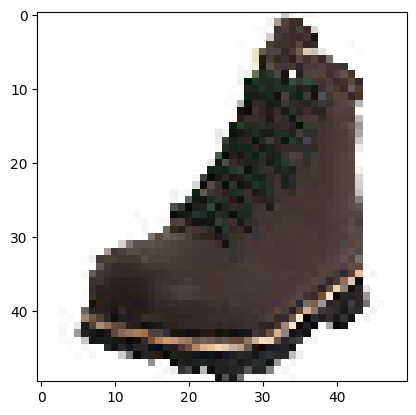

1/1 [==============================] - 0s 101ms/step
Filename: boot (1035) (3).jpg
Predicted Class: Boot


In [30]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

def predict_image(model, image_path):
  # Load and resize the image
  img = image.load_img(image_path, target_size=(50, 50))

  # Display the image
  plt.imshow(img)
  plt.show()

  # Preprocess the image
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x /= 255.0  # Normalize pixel values

  # Predict the class
  classes = model.predict(x, batch_size=10)
  predict_class_index = np.argmax(classes)

  # Load class labels (assuming they're stored in a list)
  class_labels = ["Boot", "Sandal", "Shoe"]

  predict = class_labels[predict_class_index]

  # Print results
  print(f"Filename: {image_path}")
  print(f"Predicted Class: {predict}")

# Upload the image
uploaded = files.upload()

# Process the uploaded image
if uploaded:
  image_path = list(uploaded.keys())[0]  # Get the first uploaded file path
  predict_image(model, image_path)


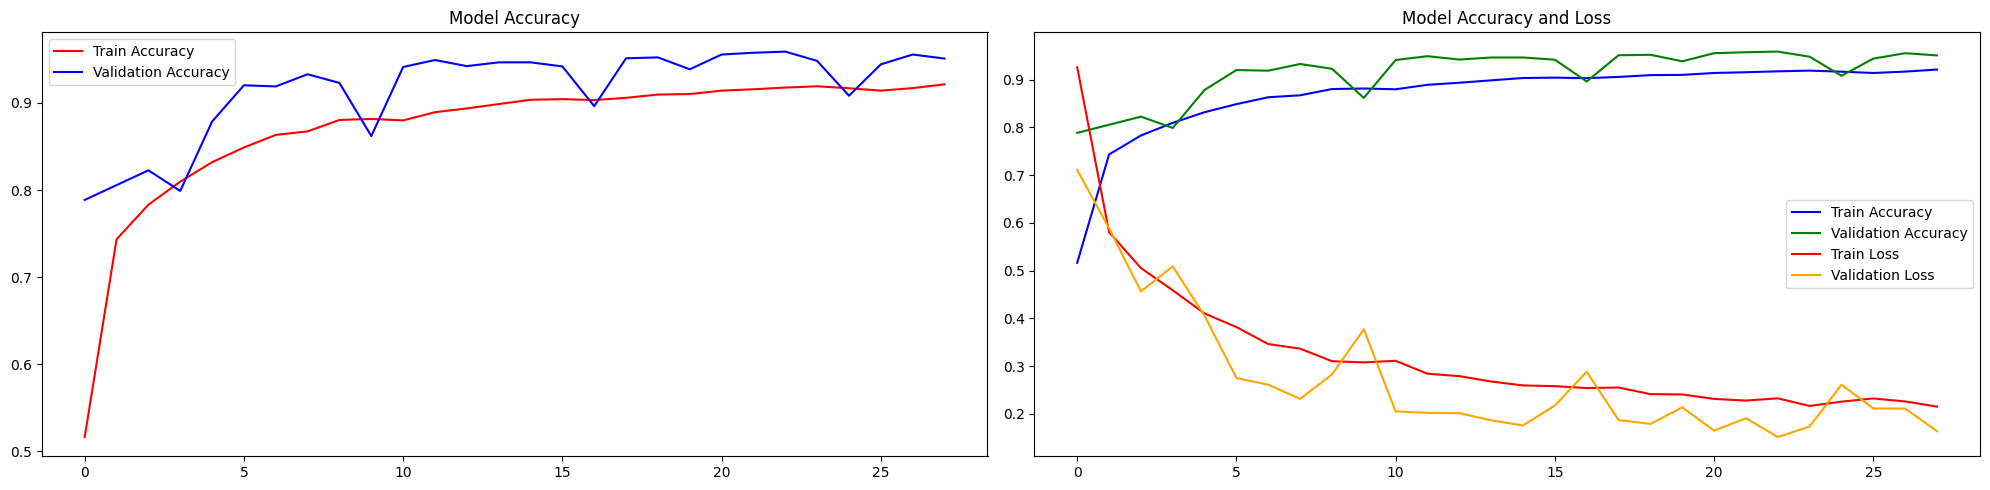

In [31]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Create a subplot figure
plt.figure(figsize=(20, 5))  # Adjust figure size as needed

# Subplot for Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(epochs, acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend(loc=0)

# Subplot for all
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(epochs, acc, 'blue', label='Train Accuracy')
plt.plot(epochs, val_acc, 'green', label='Validation Accuracy')
plt.plot(epochs, loss, 'red', label='Train Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Model Accuracy and Loss')
plt.legend(loc=0)


# Adjust layout to prevent overlapping elements
plt.tight_layout()

plt.show()

## Model Deployment

In [18]:
import tensorflow as tf
import pathlib

export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('ssbic.tflite')
tflite_model_file.write_bytes(tflite_model)


699560